<a href="https://colab.research.google.com/github/geo-tp/Keras-Colaboratory-Models/blob/main/composite_ae_convnets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Composite Auto Encoder and Mutliple Convnets Model

---



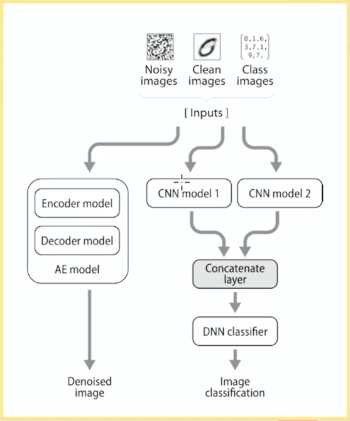

## Import

In [118]:
import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras import layers
from keras.callbacks import ModelCheckpoint, TensorBoard
from skimage.util import random_noise
from sys import path

## Parameters

In [119]:
latent_dim       = 10
batch_size       = 128
epochs           = 20
fit_verbosity    = 1
base_dir = path[0] + "/"

## Dataset and Preprocessing

In [120]:
## MNIST, 60K train img of hand writted numbers, 10K test img

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [121]:
# Normalize

train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

In [122]:
# Create a noisy dataset

def add_noise(dataset):
  """Add noise to a given dataset"""

  noised_images = []

  for image in dataset:
    noised_img = random_noise(image, mode='gaussian', mean=0, var=0.3)
    noised_img = random_noise(noised_img, mode='s&p', amount=0.2, salt_vs_pepper=0.5)
    noised_img = random_noise(noised_img, mode='poisson') 
    noised_img = random_noise(noised_img, mode='speckle',  mean=0, var=0.1)

    noised_images.append(noised_img)

  return np.array(noised_images)


noised_train_images = add_noise(train_images)
noised_test_images = add_noise(test_images)

## Models

In [125]:
# ENCODER

inputs    = keras.Input(shape=(28, 28, 1))
x         = keras.layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(inputs)
x         = keras.layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x         = keras.layers.Flatten()(x)
x         = keras.layers.Dense(16, activation="relu")(x)
z         = keras.layers.Dense(latent_dim)(x)

encoder = keras.Model(inputs, z, name="encoder")

In [126]:
# DECODER

inputs  = keras.Input(shape=(latent_dim,))
x       = keras.layers.Dense(7 * 7 * 64, activation="relu")(inputs)
x       = keras.layers.Reshape((7, 7, 64))(x)
x       = keras.layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x       = keras.layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
outputs = keras.layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

decoder = keras.Model(inputs, outputs, name="decoder")

In [127]:
# AUTO ENCODER

inputs    = keras.Input(shape=(28, 28, 1))

latents   = encoder(inputs)
outputs   = decoder(latents)

ae = keras.Model(inputs,outputs, name='ae')

In [128]:
# CONVNETS 1

inputs    = keras.Input(shape=(28, 28, 1))

x         = keras.layers.Conv2D(8, (3,3),  activation='relu')(inputs)
x         = keras.layers.MaxPooling2D((2,2))(x)
x         = keras.layers.Dropout(0.2)(x)

x         = keras.layers.Conv2D(16, (3,3), activation='relu')(x)
x         = keras.layers.MaxPooling2D((2,2))(x)
x         = keras.layers.Dropout(0.2)(x)

x         = keras.layers.Flatten()(x)
x         = keras.layers.Dense(100, activation='relu')(x)
outputs   = keras.layers.Dropout(0.5)(x)

cnn1       = keras.Model(inputs, outputs, name='cnn1')

In [129]:
# CONVNETS 2

inputs    = keras.Input(shape=(28, 28, 1))

x         = keras.layers.Conv2D(32, (5,5),  activation='relu')(inputs)
x         = keras.layers.MaxPooling2D((2,2))(x)
x         = keras.layers.Dropout(0.3)(x)

x         = keras.layers.Conv2D(64, (5,5), activation='relu')(x)
x         = keras.layers.MaxPooling2D((2,2))(x)
x         = keras.layers.Dropout(0.3)(x)

x         = keras.layers.Flatten()(x)
x         = keras.layers.Dense(50, activation='relu')(x)
outputs   = keras.layers.Dropout(0.3)(x)

cnn2       = keras.Model(inputs, outputs, name='cnn2')

In [130]:
# FINAL MODEL

inputs    = keras.Input(shape=(28, 28, 1))

denoised = ae(inputs)

branch_1 = cnn1(inputs)
branch_2 = cnn2(inputs)

x        = keras.layers.concatenate([branch_1,branch_2], axis=1)

classcat = keras.layers.Dense(10, activation='softmax', name='cnn')(x)


model = keras.Model(inputs=inputs, outputs=[denoised, classcat])

model.compile(optimizer='rmsprop', 
              loss={'ae':'binary_crossentropy', 'cnn':'sparse_categorical_crossentropy'},
              loss_weights=[1,1],
              metrics={'cnn':'accuracy'} )

model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_32 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 cnn1 (Functional)              (None, 100)          41348       ['input_32[0][0]']               
                                                                                                  
 cnn2 (Functional)              (None, 50)           103346      ['input_32[0][0]']               
                                                                                                  
 concatenate_6 (Concatenate)    (None, 150)          0           ['cnn1[0][0]',                   
                                                                  'cnn2[0][0]']             

## Training

In [131]:
callback_bestmodel = ModelCheckpoint(filepath=base_dir+"best_model.h5", verbose=0, save_best_only=True)
callback_tensorboard = TensorBoard(log_dir=base_dir, histogram_freq=1)

In [132]:
history = model.fit(noised_train_images, [train_images, train_labels],
                 batch_size      = batch_size,
                 epochs          = epochs,
                 verbose         = fit_verbosity,
                 validation_data = (noised_test_images, [test_images, test_labels]),
                 callbacks       = [callback_bestmodel, callback_tensorboard]  )

Epoch 1/20
469/469 [==============================] - 12s 17ms/step - loss: 1.3419 - ae_loss: 0.2640 - cnn_loss: 1.0778 - cnn_accuracy: 0.6272 - val_loss: 0.7176 - val_ae_loss: 0.1951 - val_cnn_loss: 0.5225 - val_cnn_accuracy: 0.8284
Epoch 2/20
469/469 [==============================] - 8s 18ms/step - loss: 0.7924 - ae_loss: 0.1850 - cnn_loss: 0.6074 - cnn_accuracy: 0.7996 - val_loss: 0.5871 - val_ae_loss: 0.1720 - val_cnn_loss: 0.4150 - val_cnn_accuracy: 0.8674
Epoch 3/20
469/469 [==============================] - 7s 16ms/step - loss: 0.6892 - ae_loss: 0.1700 - cnn_loss: 0.5191 - cnn_accuracy: 0.8301 - val_loss: 0.5284 - val_ae_loss: 0.1635 - val_cnn_loss: 0.3649 - val_cnn_accuracy: 0.8773
Epoch 4/20
469/469 [==============================] - 7s 15ms/step - loss: 0.6398 - ae_loss: 0.1633 - cnn_loss: 0.4764 - cnn_accuracy: 0.8452 - val_loss: 0.5056 - val_ae_loss: 0.1582 - val_cnn_loss: 0.3474 - val_cnn_accuracy: 0.8848
Epoch 5/20
469/469 [==============================] - 7s 16ms/step 

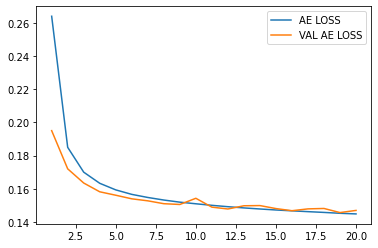

In [133]:
# LOG RESULTS - AE part

epochs_range = range(1, epochs + 1)
history_dict = history.history

cnn_acc = history_dict['cnn_accuracy']
val_cnn_acc = history_dict['val_cnn_accuracy']

ae_loss = history_dict['ae_loss']
val_ae_loss = history_dict['val_ae_loss']

plt.plot(epochs_range, ae_loss, label="AE LOSS")
plt.plot(epochs_range, val_ae_loss, label="VAL AE LOSS")

plt.legend()
plt.show()

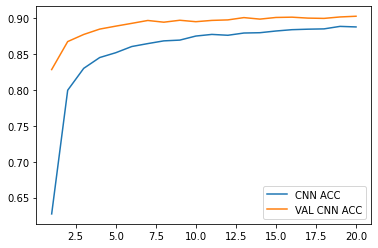

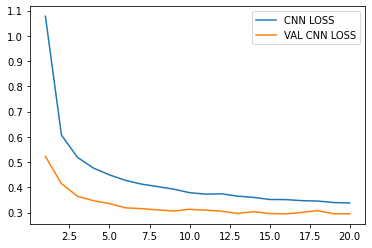

In [134]:
# LOG RESULTS - Convnets part

epochs_range = range(1, epochs + 1)
history_dict = history.history

cnn_acc = history_dict['cnn_accuracy']
val_cnn_acc = history_dict['val_cnn_accuracy']

cnn_loss = history_dict['cnn_loss']
val_cnn_loss = history_dict['val_cnn_loss']

plt.plot(epochs_range, cnn_acc, label="CNN ACC")
plt.plot(epochs_range, val_cnn_acc, label="VAL CNN ACC")
plt.legend()
plt.show()

plt.plot(epochs_range, cnn_loss, label="CNN LOSS")
plt.plot(epochs_range, val_cnn_loss, label="VAL CNN LOSS")

plt.legend()
plt.show()

# Prediction

In [135]:
denoised_images, labels = model.predict(noised_test_images)

313/313 [==============================] - 1s 3ms/step


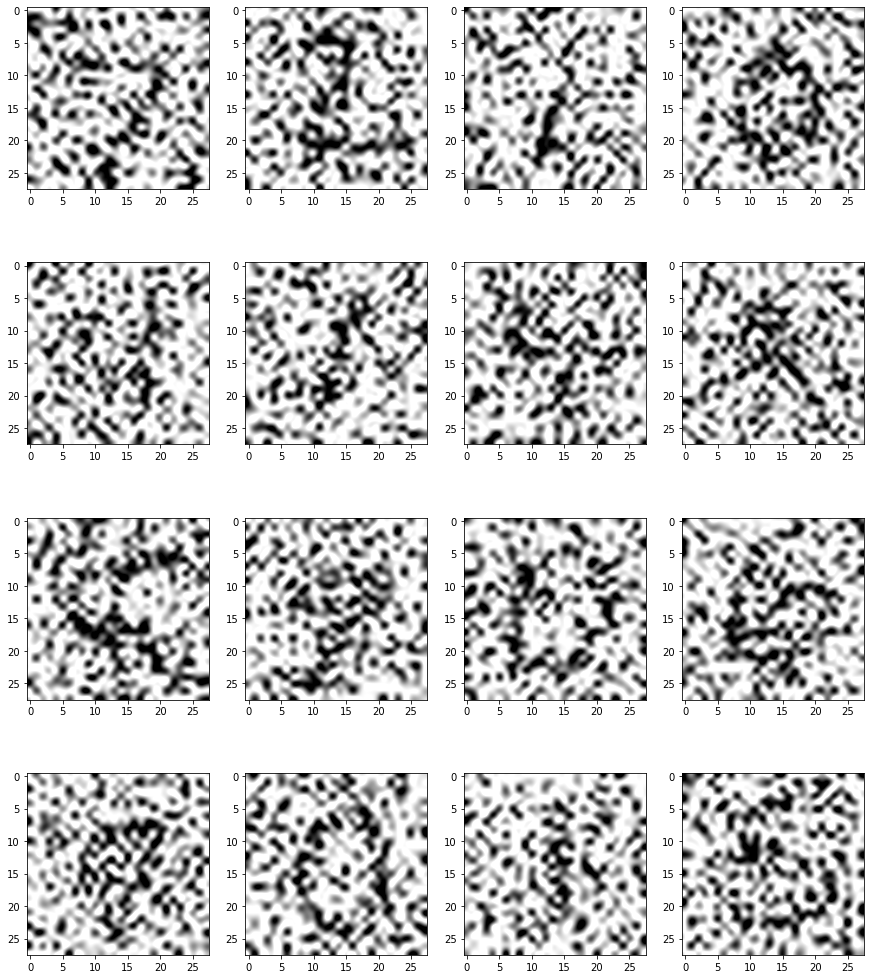

In [181]:
# The inputs with noise

fig = plt.figure(figsize=(15,18))

for i in range(1, 17):
  ax = fig.add_subplot(4, 4, i)
  ax.imshow(noised_test_images[i-1].reshape(28, 28), cmap='binary', interpolation='lanczos')

plt.show()

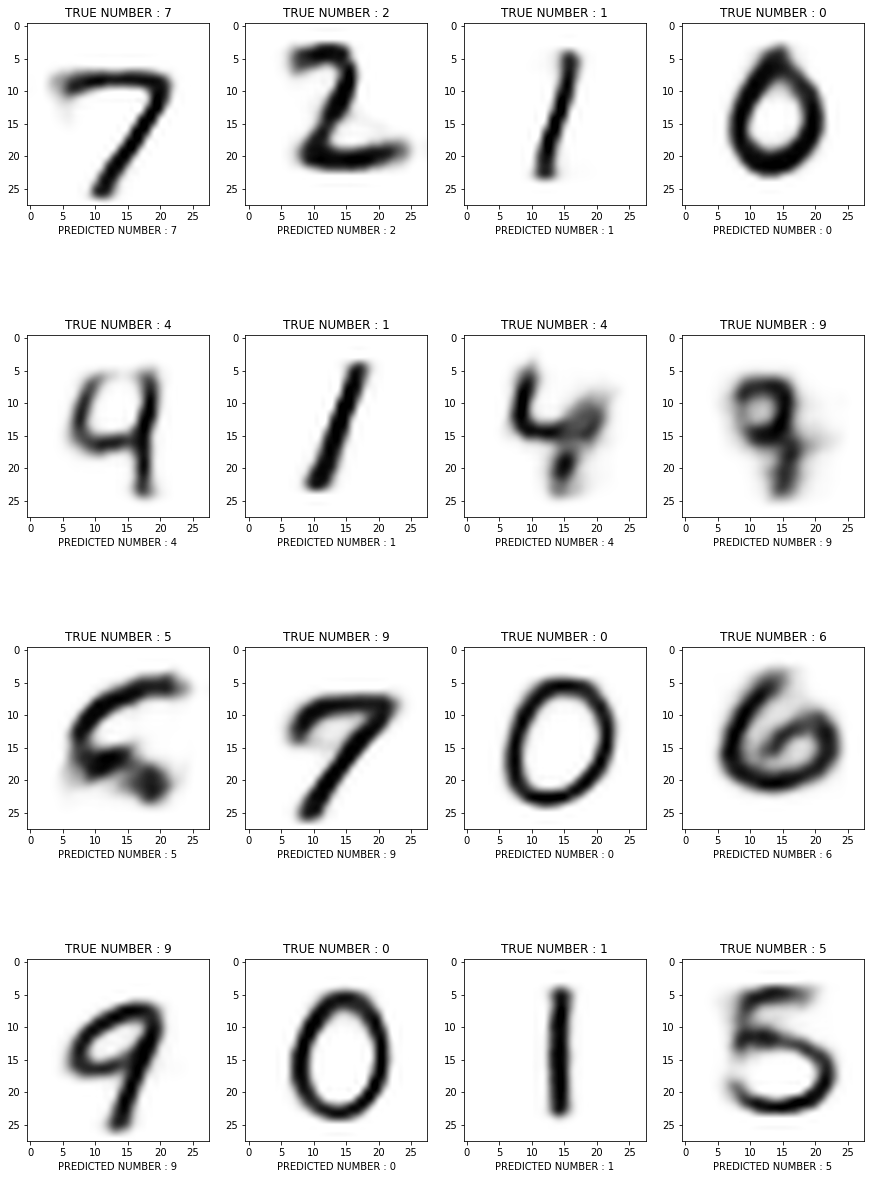

In [178]:
# The results of prediction - denoised images and classification labels

fig = plt.figure(figsize=(15,22))
for i in range(1, 17):
  ax = fig.add_subplot(4, 4, i)
  ax.imshow(denoised_images[i-1].reshape(28, 28), cmap='binary', interpolation='lanczos')
  ax.set_xlabel(f"PREDICTED NUMBER : {labels[i-1].argmax()}")
  plt.title(f"TRUE NUMBER : {test_labels[i-1]}")

plt.show()

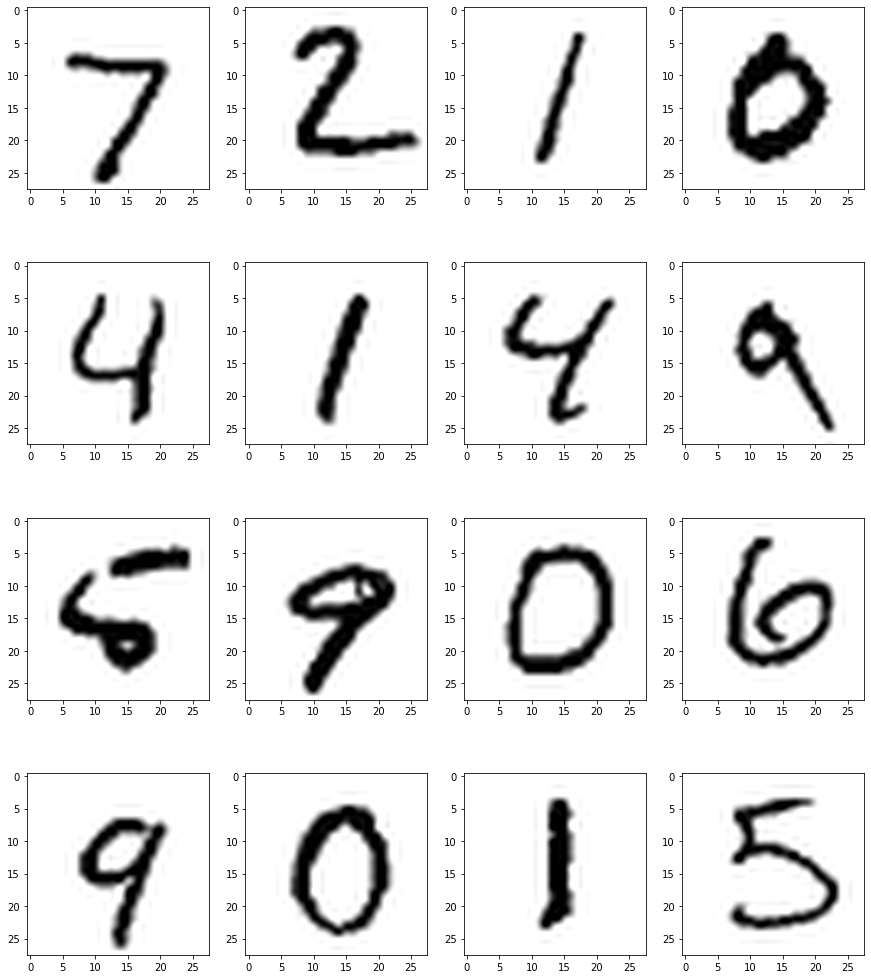

In [180]:
# The real images

fig = plt.figure(figsize=(15,18))

for i in range(1, 17):
  ax = fig.add_subplot(4, 4, i)
  ax.imshow(test_images[i-1].reshape(28, 28), cmap='binary', interpolation='lanczos')

plt.show()

In [184]:
# Evaluate

loss, ae_loss, cnn_loss, cnn_accuracy = model.evaluate(noised_test_images, [test_images, test_labels])
print("CNN Classification accuracy : {}%".format(cnn_accuracy*100))

313/313 [==============================] - 2s 7ms/step - loss: 0.4423 - ae_loss: 0.1470 - cnn_loss: 0.2953 - cnn_accuracy: 0.9027
CNN Classification accuracy : 90.27000069618225%
